<a href="https://colab.research.google.com/github/madhav2381/Pneumonia-Classification/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload dataset on drive and mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/pneumonia_dataset.zip' '/content/' 
!unzip 'pneumonia_dataset.zip'

Archive:  pneumonia_dataset.zip
   creating: pneumonia_dataset/
  inflating: pneumonia_dataset/sample_submission.csv  
   creating: pneumonia_dataset/test/
  inflating: pneumonia_dataset/test/CXR_test_1.png  
  inflating: pneumonia_dataset/test/CXR_test_10.png  
  inflating: pneumonia_dataset/test/CXR_test_100.png  
  inflating: pneumonia_dataset/test/CXR_test_101.png  
  inflating: pneumonia_dataset/test/CXR_test_102.png  
  inflating: pneumonia_dataset/test/CXR_test_103.png  
  inflating: pneumonia_dataset/test/CXR_test_104.png  
  inflating: pneumonia_dataset/test/CXR_test_105.png  
  inflating: pneumonia_dataset/test/CXR_test_106.png  
  inflating: pneumonia_dataset/test/CXR_test_107.png  
  inflating: pneumonia_dataset/test/CXR_test_108.png  
  inflating: pneumonia_dataset/test/CXR_test_109.png  
  inflating: pneumonia_dataset/test/CXR_test_11.png  
  inflating: pneumonia_dataset/test/CXR_test_110.png  
  inflating: pneumonia_dataset/test/CXR_test_111.png  
  inflating: pneumonia_

# Import Dependencies

In [ ]:
from PIL import Image
import shutil
import cv2
import os
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import random
import pickle
import glob
from skimage.filters import sobel
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
#from tf.keras.utils import to_categorical
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import batch_normalization
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

# Data Pre-processing 

In [ ]:
image1 = np.array(Image.open('/content/pneumonia_dataset/train/normal/CXR_train_1000.png'))
image1.shape

(1024, 1024)

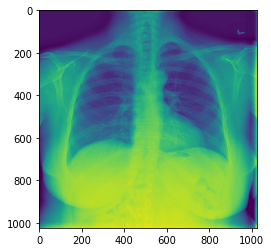

In [ ]:
plt.imshow(image1);

In [ ]:
image2 = np.array(Image.open('/content/pneumonia_dataset/train/pneumonia/CXR_train_1012.png'))
image2.shape

(1024, 1024)

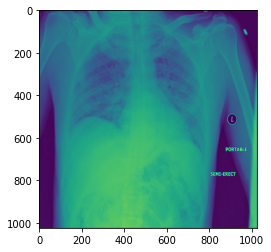

In [ ]:
plt.imshow(image2);

In [ ]:
df = pd.read_csv('/content/pneumonia_dataset/test.csv')
df.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


In [ ]:
train_images = []
train_labels = [] 
SIZE = 224
for directory_path in glob.glob("/content/pneumonia_dataset/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
print(train_images.shape)
print(train_labels.shape)

(2425, 224, 224, 3)
(2425,)


In [ ]:
#Encode labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets
x_train,  x_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2)

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
#One hot encode y values

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Feature extractor + Random Forest

In [ ]:
# Feature Extractor

featuremodel = Sequential()
featuremodel.add(Conv2D(16,3,padding='valid',input_shape = (224, 224, 3)))
featuremodel.add(Activation('sigmoid'))
featuremodel.add(BatchNormalization())

featuremodel.add(Conv2D(32,3,padding='valid'))
featuremodel.add(Activation('sigmoid'))
featuremodel.add(BatchNormalization())
featuremodel.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

featuremodel.add(Conv2D(64,3,padding='valid'))
featuremodel.add(Activation('sigmoid'))
featuremodel.add(BatchNormalization())

featuremodel.add(Conv2D(64,3,padding='valid'))
featuremodel.add(Activation('sigmoid'))
featuremodel.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

featuremodel.add(Flatten())

x = featuremodel.output

In [ ]:
x = Dense(224, activation='sigmoid', kernel_initializer='he_uniform')(x)
prediction_layer = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs = featuremodel.input, outputs= prediction_layer)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 220, 220, 32)      0         
                                                           

In [ ]:
history = model.fit(x_train, y_train_one_hot, epochs =100, validation_data=(x_test,y_test_one_hot))

Epoch 1/100
61/61 [==============================] - 16s 265ms/step - loss: 0.6959 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5155
Epoch 2/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6939 - accuracy: 0.5268 - val_loss: 0.6928 - val_accuracy: 0.5155
Epoch 3/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6955 - accuracy: 0.5052 - val_loss: 0.6972 - val_accuracy: 0.4845
Epoch 4/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6966 - accuracy: 0.5165 - val_loss: 0.7014 - val_accuracy: 0.5155
Epoch 5/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6964 - accuracy: 0.4969 - val_loss: 0.7127 - val_accuracy: 0.5155
Epoch 6/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6964 - accuracy: 0.5082 - val_loss: 0.7017 - val_accuracy: 0.5155
Epoch 7/100
61/61 [==============================] - 16s 259ms/step - loss: 0.6962 - accuracy: 0.5082 - val_loss: 0.6944 - val_accuracy:

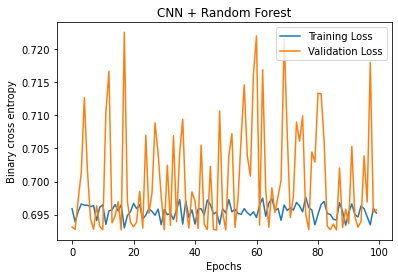

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("CNN + Random Forest")
plt.show()

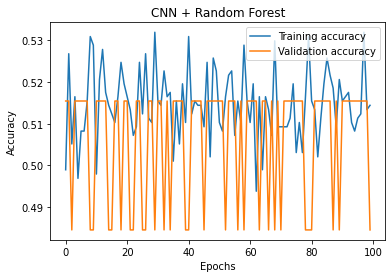

In [ ]:
#plot the training history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('model_training_history')
plt.title("CNN + Random Forest")
plt.show()

# Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
rescale=1/255.0,
rotation_range=7,
width_shift_range=0.5,
height_shift_range=0.45,
shear_range=0.2,
zoom_range=0.45,
horizontal_flip=True,
validation_split = 0.2
)

test_datagen=ImageDataGenerator(
rescale=1/255.0
)

In [ ]:
train_set=train_datagen.flow_from_directory('/content/pneumonia_dataset/train',
target_size=(224, 224),
batch_size=32,
shuffle=True,
class_mode='binary',
subset = 'training')

validation_set = train_datagen.flow_from_directory('/content/pneumonia_dataset/train',
                                                   target_size = (224, 224),
                                                   batch_size = 32,
                                                   shuffle = True,
                                                   class_mode = 'binary',
                                                   subset = 'validation'
                                                   )

test_generator=test_datagen.flow_from_dataframe(
dataframe=df,
directory="/content/pneumonia_dataset/test",
x_col="filename",
y_col=None,
batch_size=32,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 1940 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 606 validated image filenames.


# ANN

In [ ]:
# ANN

model_ann = Sequential()
model_ann.add(Dense(16, input_shape= (224,224,3), activation='relu'))
model_ann.add(Dropout(0.4))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dropout(0.6))
model_ann.add(Flatten())
model_ann.add(Dense(1, activation='sigmoid'))

model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ann.summary())

#create callback
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=2, verbose=2, mode='min')

callbacks = [checkpoint, lr_reduce]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 224, 224, 16)      64        
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 dense_5 (Dense)             (None, 224, 224, 32)      544       
                                                                 
 dropout_1 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 1605632)           0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1605633   
                                                                 
Total params: 1,606,241
Trainable params: 1,606,241
No

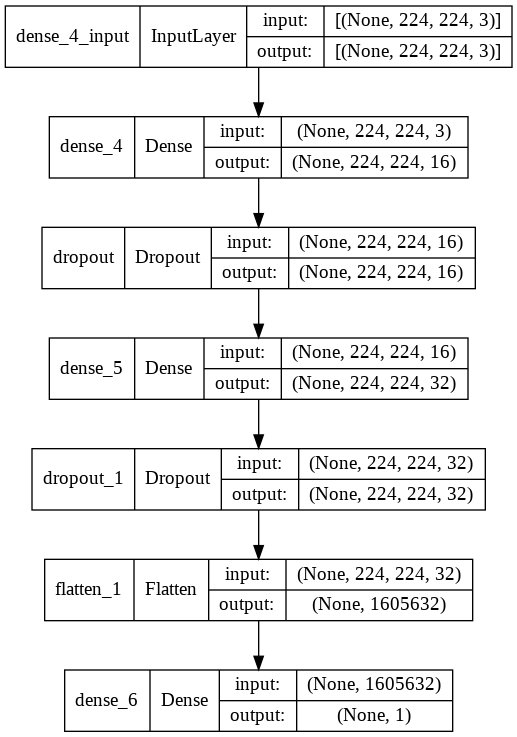

In [ ]:
tf.keras.utils.plot_model(model_ann, show_shapes = True, show_layer_names= True)

In [ ]:
#fit the model
history = model_ann.fit_generator(train_set, validation_data = validation_set, epochs=30, callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5567
Epoch 00001: val_loss did not improve from 0.69092
61/61 [==============================] - 58s 956ms/step - loss: 0.6878 - accuracy: 0.5567 - val_loss: 0.6955 - val_accuracy: 0.4722 - lr: 8.7752e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5474
Epoch 00002: val_loss did not improve from 0.69092
61/61 [==============================] - 58s 946ms/step - loss: 0.6881 - accuracy: 0.5474 - val_loss: 0.6956 - val_accuracy: 0.4722 - lr: 8.7752e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5479
Epoch 00003: val_loss did not improve from 0.69092

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0008687459060456604.
61/61 [==============================] - 58s 956ms/step - loss: 0.6886 - accuracy: 0.5479 - val_loss: 0.6956 - val_accuracy: 0.4722 - lr: 8.7752e-04


In [ ]:
from google.colab import files
files.download('my_best_model.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
score = model_ann.evaluate_generator(validation_set, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 12s 743ms/step - loss: 0.6955 - accuracy: 0.4722
Test accuracy: 0.47216495871543884


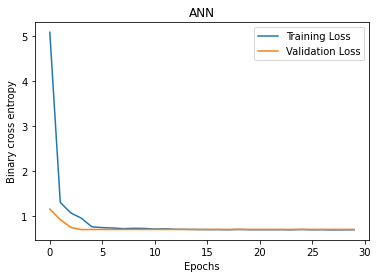

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("ANN")
plt.show()

# CNN with DROPOUT

In [ ]:
# CNN with DROPOUT

model_cnn = Sequential()
model_cnn.add(Conv2D(16,(5,5),padding='valid',input_shape = (224, 224, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Conv2D(32,(5,5),padding='valid'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Conv2D(64,(5,5),padding='valid'))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.8))
model_cnn.add(Flatten())
model_cnn.add(Dense(1))
model_cnn.add(Activation('sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001, decay = 1e-6)
model_cnn.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
print(model_cnn.summary())

#create callback
filepath = 'my_best_cnn_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=2, verbose=2, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='min')

callbacks = [checkpoint, lr_reduce, early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0         
                                                        

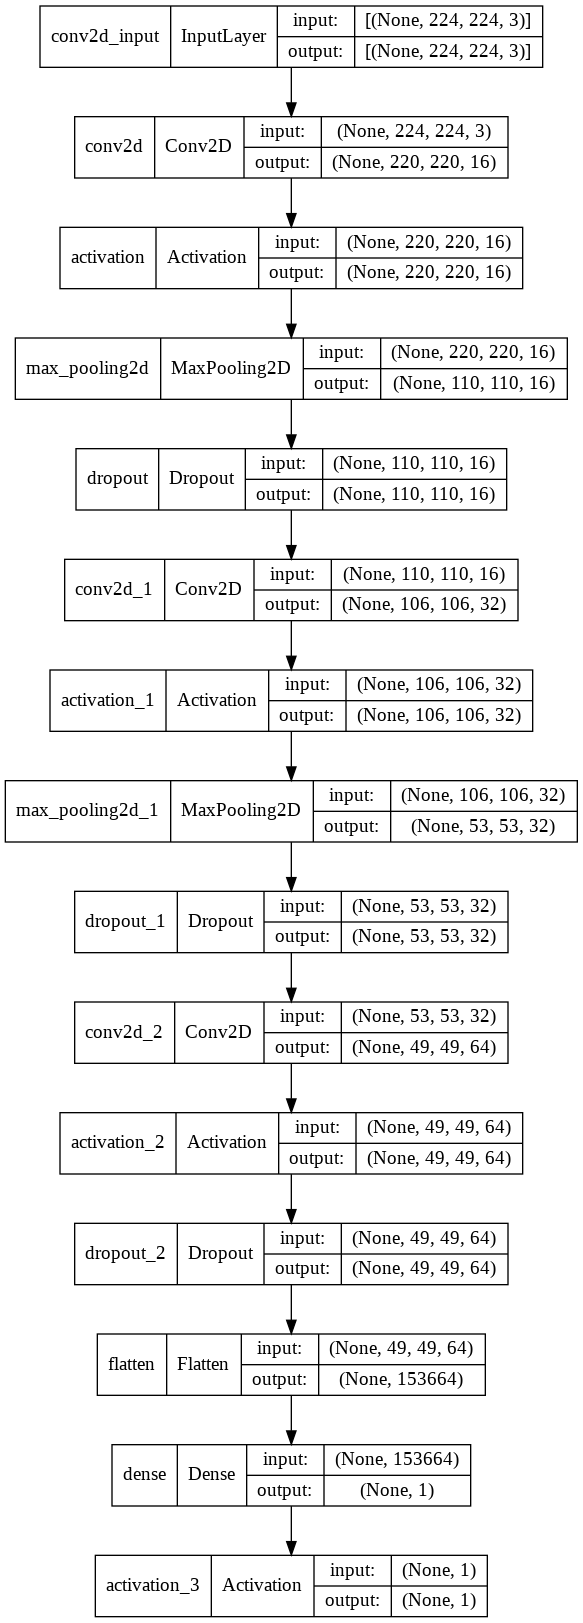

In [ ]:
tf.keras.utils.plot_model(model_cnn, show_shapes = True, show_layer_names= True)

In [ ]:
#fit the model
history = model_cnn.fit_generator(train_set, validation_data = validation_set, epochs=30, callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.5278 - precision_1: 0.5000 - recall_1: 0.3941
Epoch 00001: val_loss improved from inf to 0.69092, saving model to my_best_cnn_model.hdf5
61/61 [==============================] - 67s 946ms/step - loss: 0.7252 - accuracy: 0.5278 - precision_1: 0.5000 - recall_1: 0.3941 - val_loss: 0.6909 - val_accuracy: 0.5278 - val_precision_1: 0.5000 - val_recall_1: 0.0175 - lr: 1.0000e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.5201 - precision_1: 0.4858 - recall_1: 0.2795
Epoch 00002: val_loss did not improve from 0.69092
61/61 [==============================] - 57s 932ms/step - loss: 0.7032 - accuracy: 0.5201 - precision_1: 0.4858 - recall_1: 0.2795 - val_loss: 0.6926 - val_accuracy: 0.5237 - val_precision_1: 0.4545 - val_recall_1: 0.0437 - lr: 1.0000e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5232 - precision_1: 0

In [ ]:
files.download('my_best_cnn_model.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
score = model_cnn.evaluate_generator(validation_set, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 11s 688ms/step - loss: 0.6924 - accuracy: 0.5278 - precision_1: 0.5000 - recall_1: 0.0087
Test accuracy: 0.5278350710868835


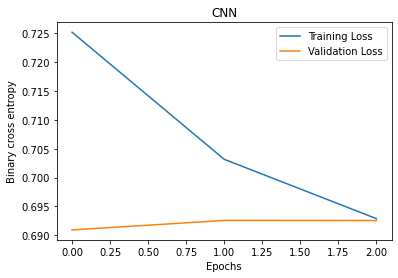

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("CNN")
plt.show()

# CNN with DROPOUT + BATCH_NORMALISATION

In [ ]:
# CNN with DROPOUT + BATCH_NORMALISATION

model_cnn1 = Sequential()
model_cnn1.add(Conv2D(16,(5,5),padding='valid',input_shape = (224, 224, 3)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(BatchNormalization(axis=3))
model_cnn1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn1.add(Conv2D(32,(5,5),padding='valid'))
model_cnn1.add(Activation('relu'))
model_cnn1.add(BatchNormalization(axis=3))
model_cnn1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn1.add(Conv2D(64,(5,5),padding='valid'))
model_cnn1.add(Activation('relu'))
model_cnn1.add(BatchNormalization(axis=3))
model_cnn1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Flatten())
model_cnn1.add(Dense(1))
model_cnn1.add(Activation('sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(lr = 0.0005, decay = 1e-6)
model_cnn1.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
print(model_cnn1.summary())

#create callback
filepath = 'my_best_cnn1_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=2, verbose=2, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='min')

callbacks = [checkpoint, lr_reduce, early_stop]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 220, 220, 16)      1216      
                                                                 
 activation_8 (Activation)   (None, 220, 220, 16)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 220, 220, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_9 (Activation)   (None, 106, 106, 32)     

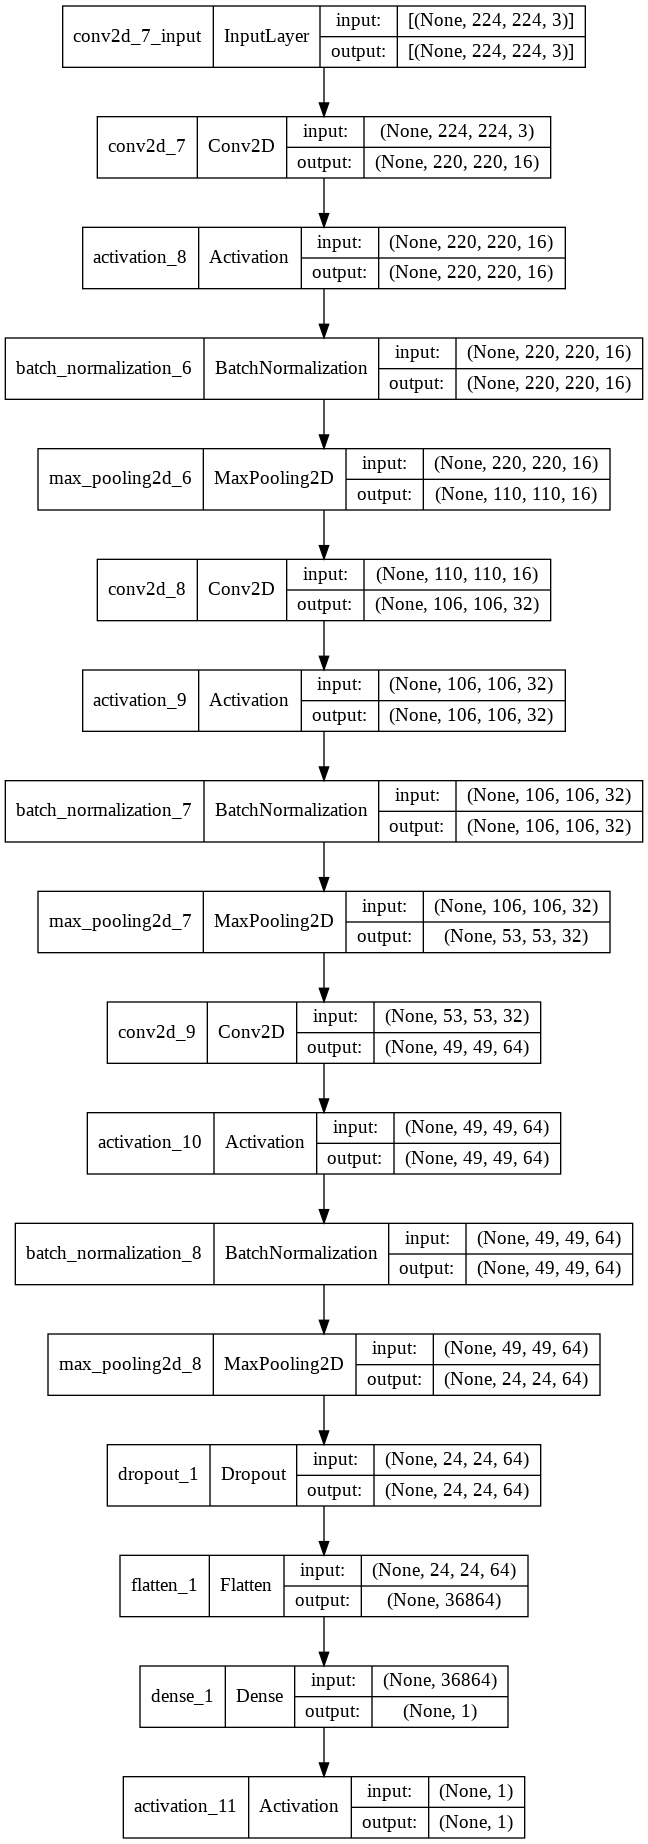

In [ ]:
tf.keras.utils.plot_model(model_cnn1, show_shapes = True, show_layer_names= True)

In [ ]:
#fit the model
history = model_cnn1.fit_generator(train_set, validation_data = validation_set, epochs=30, callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 1.5961 - accuracy: 0.5165 - precision: 0.4884 - recall: 0.5044
Epoch 00001: val_loss improved from inf to 0.76041, saving model to my_best_cnn1_model.hdf5
61/61 [==============================] - 76s 1s/step - loss: 1.5961 - accuracy: 0.5165 - precision: 0.4884 - recall: 0.5044 - val_loss: 0.7604 - val_accuracy: 0.5320 - val_precision: 0.5250 - val_recall: 0.0917 - lr: 5.0000e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 1.5605 - accuracy: 0.5082 - precision: 0.4790 - recall: 0.4738
Epoch 00002: val_loss improved from 0.76041 to 0.73423, saving model to my_best_cnn1_model.hdf5
61/61 [==============================] - 63s 1s/step - loss: 1.5605 - accuracy: 0.5082 - precision: 0.4790 - recall: 0.4738 - val_loss: 0.7342 - val_accuracy: 0.5381 - val_precision: 0.5100 - val_recall: 0.5590 - lr: 5.0000e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 1.4694 - accuracy: 0.5196 

In [ ]:
files.download('my_best_cnn1_model.hdf5')

In [ ]:
score = model_cnn1.evaluate_generator(validation_set, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 12s 764ms/step - loss: 0.9481 - accuracy: 0.4928 - precision: 0.4653 - recall: 0.4978
Test accuracy: 0.4927835166454315


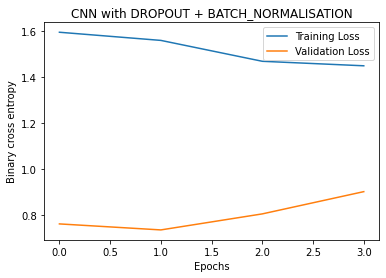

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("CNN with DROPOUT + BATCH_NORMALISATION")
plt.show()

In [ ]:
# learning rate : 0.0001

optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001, decay = 1e-6)
model_cnn1.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
#fit the model
history = model_cnn1.fit_generator(train_set, validation_data = validation_set, epochs=30, callbacks=callbacks)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.5191 - precision_1: 0.4909 - recall_1: 0.4989
Epoch 00001: val_loss did not improve from 0.73423
61/61 [==============================] - 67s 1s/step - loss: 1.0668 - accuracy: 0.5191 - precision_1: 0.4909 - recall_1: 0.4989 - val_loss: 0.8408 - val_accuracy: 0.5443 - val_precision_1: 0.5160 - val_recall_1: 0.5633 - lr: 1.0000e-04
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.5160 - precision_1: 0.4876 - recall_1: 0.4956
Epoch 00002: val_loss did not improve from 0.73423
61/61 [==============================] - 64s 1s/step - loss: 1.0585 - accuracy: 0.5160 - precision_1: 0.4876 - recall_1: 0.4956 - val_loss: 0.7713 - val_accuracy: 0.4948 - val_precision_1: 0.4786 - val_recall_1: 0.7817 - lr: 1.0000e-04
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.5186 - precision_1: 0.4899 - recall_1: 0.4782
Epoch 00003: val_loss

In [ ]:
score = model_cnn1.evaluate_generator(validation_set, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 12s 753ms/step - loss: 0.7735 - accuracy: 0.5546 - precision_1: 0.5199 - recall_1: 0.7424
Test accuracy: 0.5546391606330872


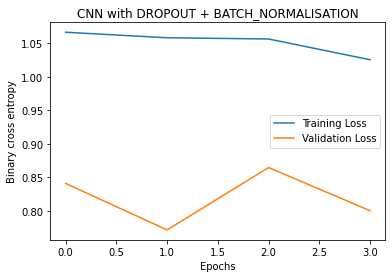

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("CNN with DROPOUT + BATCH_NORMALISATION")
plt.show()

# Inception V3 - IMAGENET

In [ ]:
# imagenet architecture

inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(224,224,3),weights='imagenet')
layer=inception.get_layer('mixed7')
x=tf.keras.layers.Flatten()(layer.output)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model_net=tf.keras.Model(inputs=inception.input,outputs=out)

model_net.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
print(model_net.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)              

In [ ]:
tf.keras.utils.plot_model(model_net, show_shapes = True, show_layer_names= True)

In [ ]:
# fit the model
history = model_net.fit_generator(train_set, validation_data = validation_set, epochs=50, callbacks = callbacks)

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.5701 - precision: 0.5447 - recall: 0.5459
Epoch 00001: val_loss improved from inf to 1.20997, saving model to my_best_model.hdf5
61/61 [==============================] - 108s 2s/step - loss: 0.7770 - accuracy: 0.5701 - precision: 0.5447 - recall: 0.5459 - val_loss: 1.2100 - val_accuracy: 0.5814 - val_precision: 0.7826 - val_recall: 0.1572 - lr: 1.0000e-04
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.6557 - precision: 0.6316 - recall: 0.6496
Epoch 00002: val_loss improved from 1.20997 to 0.87591, saving model to my_best_model.hdf5
61/61 [==============================] - 82s 1s/step - loss: 0.6425 - accuracy: 0.6557 - precision: 0.6316 - recall: 0.6496 - val_loss: 0.8759 - val_accuracy: 0.6206 - val_precision: 0.8462 - val_recall: 0.2402 - lr: 1.0000e-04
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6830 - precisi

In [ ]:
score = model_net.evaluate_generator(validation_set, verbose=1)
print('Test accuracy:', score[1])

16/16 [==============================] - 14s 835ms/step - loss: 2.5263 - accuracy: 0.6660 - precision: 0.6502 - recall: 0.6332
Test accuracy: 0.6659793853759766


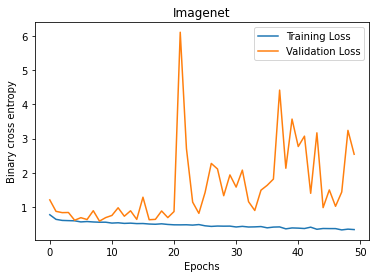

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("Imagenet")
plt.show()

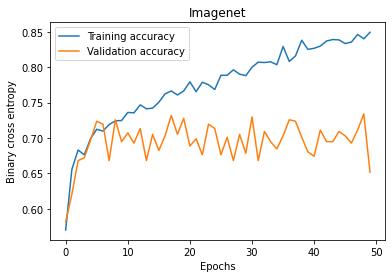

In [ ]:
#plot the training history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.savefig('model_training_history')
plt.title("Imagenet")
plt.show()